In [12]:
import jax
from jax import numpy as jnp, random
import numpy as np
import pandas as pd
from mondeq.modules import MonLinear, Relu, fcmon, deq_forward, _fp_bwd
from mondeq.splittings import build_peacemanrachford_update
from utils import commutation_matrix_sp, vec
from functools import partial
import pandas as pd


In [31]:
dyn = partial(build_peacemanrachford_update, 1.)
def stats_TK(d, k, Z0, X, key):
    X = X / jnp.linalg.norm(X, axis=0)

    skey = random.split(key)
    lin_module = MonLinear(d, k, key=skey[0])
    nonlin_module = Relu()
    u = random.normal(skey[1], shape=(k,)) / jnp.sqrt(k)
    Ju = jax.jacrev(lambda u: fcmon(dyn, max_iter, tol, u, nonlin_module, lin_module, Z0, X))(u)
    Jlin = jax.jacrev(lambda lin_module: fcmon(dyn, max_iter, tol, u, nonlin_module, lin_module, Z0, X), allow_int=True)(lin_module)
    
    Z_star, res = deq_forward(dyn, max_iter, tol, nonlin_module, lin_module, Z0, X)
    S = nonlin_module.derivative(Z_star)
    V = _fp_bwd(dyn, max_iter, tol, nonlin_module, res, u)
    Q = V * S
    QQ = Q @ Q.T
    diag_QQ = jnp.diag(jnp.abs(QQ))
    rsum_aQQ = jnp.sum(jnp.abs(QQ), axis=1)
    disc = 2*diag_QQ - rsum_aQQ


    H1_A = vprod(Jlin.p_A)
    H1_B = vprod(Jlin.p_B)

    H1 = H1_A + H1_B
    H2 = vprod(Jlin.p_U)
    H3 = Ju @ Ju.T
    H = H1 + H2 + H3



    return {
        "min_disc": jnp.min(disc),
        "min_norm_row_Q": jnp.min(jnp.diag(H2)),
        "eigmin_H1_A": jnp.linalg.eigvalsh(H1_A)[0],
        "eigmin_H1_B": jnp.linalg.eigvalsh(H1_B)[0],

        "eigmin_H1": jnp.linalg.eigvalsh(H1)[0],
        "eigmin_H2": jnp.linalg.eigvalsh(H2)[0],
        "eigmin_H3": jnp.linalg.eigvalsh(H3)[0],

        "eigmin_H": jnp.linalg.eigvalsh(H)[0],
    }
stats_TK_jit = jax.jit(stats_TK, static_argnums=(0, 1))

In [32]:
num_runs = 1000
num_samples = 5
d = 20
k = 500
key = random.PRNGKey(0)
max_iter = 100
tol = 1e-5
def vprod(M):
    return jnp.einsum("ihk,jhk->ij", M, M)

In [33]:
Z0 = jnp.zeros(shape=(num_samples, k))
row_list = []
for i in range(num_runs):
    key, skey = random.split(key)
    X = np.random.uniform(size=(num_samples, d))
    result = stats_TK_jit(d, k, Z0, X, skey)
    result = {k: v.item() for k, v in result.items()}
    row_list.append(result)
df = pd.DataFrame(row_list)

In [34]:
df  

,eigmin_H,eigmin_H1,eigmin_H1_A,eigmin_H1_B,eigmin_H2,eigmin_H3,min_disc,min_norm_row_Q
0,1.991949,1.121802,0.383389,0.737610,0.667531,0.165946,-1.019215,1.824161
1,3.346905,2.102114,0.678612,1.420946,0.945621,0.278954,-1.238724,2.656116
2,3.491908,1.940951,0.661392,1.278342,1.159487,0.311862,-0.817311,2.101906
3,2.771504,1.526891,0.499986,1.025892,0.880906,0.259917,-0.832316,1.644391
4,3.010909,1.569671,0.560540,0.999793,1.091830,0.287570,-1.041545,2.116324
...,...,...,...,...,...,...,...,...
995,2.030820,1.097216,0.365654,0.728630,0.691707,0.181652,-1.030288,1.524220
996,2.773143,1.599351,0.533422,1.061393,0.887877,0.229973,-0.867948,1.789534
997,2.761006,1.501326,0.495383,1.004031,0.977883,0.262952,-0.921784,2.084951
998,3.363046,1.926060,0.642227,1.280967,1.053717,0.297383,-0.923047,1.845796


In [27]:
df.min()

eigmin_H          1.042311
eigmin_H1         0.587888
eigmin_H1_A       0.209653
eigmin_H1_B       0.378203
eigmin_H2         0.335110
eigmin_H3         0.074899
min_disc         -1.794751
min_norm_row_Q    1.029364
dtype: float64

In [28]:
df.mean()

eigmin_H          2.893156
eigmin_H1         1.665299
eigmin_H1_A       0.551164
eigmin_H1_B       1.111751
eigmin_H2         0.924640
eigmin_H3         0.253527
min_disc         -1.073218
min_norm_row_Q    1.964848
dtype: float64

<AxesSubplot:ylabel='Frequency'>

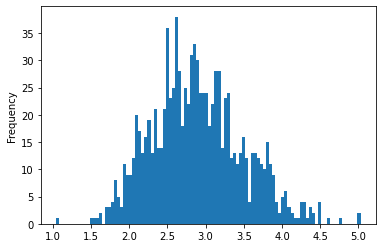

In [29]:
df.eigmin_H.plot.hist(bins=100)

In [79]:
df.min()

eigmin_H          1.223016e-06
eigmin_H1         7.194511e-07
eigmin_H1_A       2.549738e-07
eigmin_H1_B       4.750988e-07
eigmin_H2         2.368104e-07
eigmin_H3         7.847345e-10
min_norm_row_Q    7.859664e-04
dtype: float64

<AxesSubplot:ylabel='Frequency'>

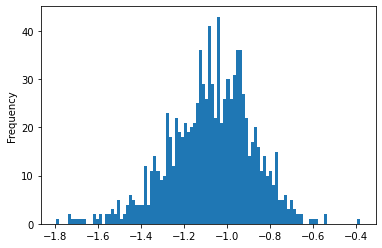

In [30]:
df.min_disc.plot.hist(bins=100)

In [92]:
(df.eigmin_H < df.eigmin_H.min()*2).sum()

27